In [1]:
import sys, os
import numpy as np
import time, h5py
codepath = '/user_data/mmhender/imStat/code'
sys.path.append(codepath)
from utils import default_paths, coco_utils, nsd_utils, numpy_utils, stats_utils
from model_fitting import initialize_fitting 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import argparse
import pandas as pd   

Initializing coco api...
loading annotations into memory...
Done (t=0.73s)
creating index...
index created!
loading annotations into memory...
Done (t=16.18s)
creating index...
index created!
Initializing coco api...
loading annotations into memory...
Done (t=0.57s)
creating index...
index created!
loading annotations into memory...
Done (t=15.41s)
creating index...
index created!


In [116]:
subject=1
which_prf_grid=4
stuff=1
mm=5

if which_prf_grid!=1:
    folder2save = os.path.join(default_paths.stim_labels_root, 'S%d_within_prf_grid%d'%(subject, which_prf_grid))
else:
    folder2save = os.path.join(default_paths.stim_labels_root, 'S%d_within_prf'%subject)
if not os.path.exists(folder2save):
    os.makedirs(folder2save)       
fn2save =  os.path.join(folder2save,'S%d_cocolabs'%subject)
if stuff:
    fn2save += '_stuff'
fn2save += '_binary'
fn2save += '_prf%d.csv'%(mm)

print('Saving to %s'%fn2save)

Saving to /user_data/mmhender/nsd_stimuli/labels/S1_within_prf/S1_cocolabs_stuff_binary_grid4_prf5.csv


In [109]:
fn2save =  os.path.join(folder2save,'S%d_cocolabs'%subject)
if stuff:
    fn2save += '_stuff'
fn2save += '_binary'
# fn2save
fn2save += '_prf%d.csv'%(mm)

fn2save

'/user_data/mmhender/nsd_stimuli/labels/S1_within_prf/S1_cocolabs_stuff_binary_prf3.csv'

In [2]:
subject =1;
discrim_type='animacy';
debug=False

In [3]:
# load full-dimension features, already computed 
path_to_load = default_paths.sketch_token_feat_path
features_file = os.path.join(path_to_load, 'S%d_features_each_prf_grid3.h5py'%(subject))
if not os.path.exists(features_file):
    raise RuntimeError('Looking at %s for precomputed features, not found.'%features_file)   
print('Loading pre-computed features from %s'%features_file)
t = time.time()
with h5py.File(features_file, 'r') as data_set:
    values = np.copy(data_set['/features'][:,:,0:10])
    data_set.close() 
elapsed = time.time() - t
print('Took %.5f seconds to load file'%elapsed)
features_each_prf = values
n_features = 150
features_each_prf = features_each_prf[:,0:n_features,:]

Loading pre-computed features from /user_data/mmhender/features/sketch_tokens/S1_features_each_prf_grid3.h5py
Took 20.60771 seconds to load file


In [4]:
values.shape

(10000, 151, 10)

In [5]:
# how to do z-scoring? can set up groups of columns here.
zgroup_labels = np.concatenate([np.zeros(shape=(1,150)), np.ones(shape=(1,1))], axis=1)
zgroup_labels = zgroup_labels[0,0:n_features]


In [25]:
# training / validation data always split the same way - shared 1000 inds are validation.
subject_df = nsd_utils.get_subj_df(subject)
valinds = np.array(subject_df['shared1000'])
trninds = np.array(subject_df['shared1000']==False)

print('Size of features array for this image set is:')
print(features_each_prf.shape)

# Params for the spatial aspect of the model (possible pRFs)
aperture_rf_range = 1.1
which_prf_grid=1
aperture, models = initialize_fitting.get_prf_models(aperture_rf_range=aperture_rf_range, \
                                                     which_grid=which_prf_grid)    
n_prfs = models.shape[0]


Size of features array for this image set is:
(10000, 150, 10)
number of pRFs: 875
most extreme RF positions:
[-0.55 -0.55  0.04]
[0.55       0.55       0.40000001]


In [9]:
prf_model_index = 0
coco_labels_fn = os.path.join(default_paths.stim_labels_root, 'S%d_within_prf'%subject, \
                                          'S%d_cocolabs_binary_prf%d.csv'%(subject, prf_model_index))
print('Reading labels from %s...'%coco_labels_fn)
coco_df = pd.read_csv(coco_labels_fn, index_col=0)
labels = np.array(coco_df['has_animate'])
unvals = np.unique(labels)
print('Overall proportion animate this pRF:')
print(np.mean(labels==1))
print('Proportion w any annotation this pRF:')
mat = np.array(coco_df)
ims_to_use = np.any(mat, axis=1)
print(np.mean(ims_to_use))
ims_to_use = np.ones(np.shape(labels))==1


Reading labels from /user_data/mmhender/nsd_stimuli/labels/S1_within_prf/S1_cocolabs_binary_prf0.csv...
Overall proportion animate this pRF:
0.0636
Proportion w any annotation this pRF:
0.1918


In [20]:
path_to_save = os.path.join(path_to_load, 'LDA')
fn2save = os.path.join(path_to_save, 'S%d_LDA_%s.npy'%(subject, discrim_type))
lda_result = np.load(fn2save,allow_pickle=True).item()

In [98]:
discrim_type='person'
path_to_save = os.path.join(path_to_load, 'LDA')
fn2save = os.path.join(path_to_save, 'S%d_LDA_%s.npy'%(subject, discrim_type))
lda_result = np.load(fn2save,allow_pickle=True).item()

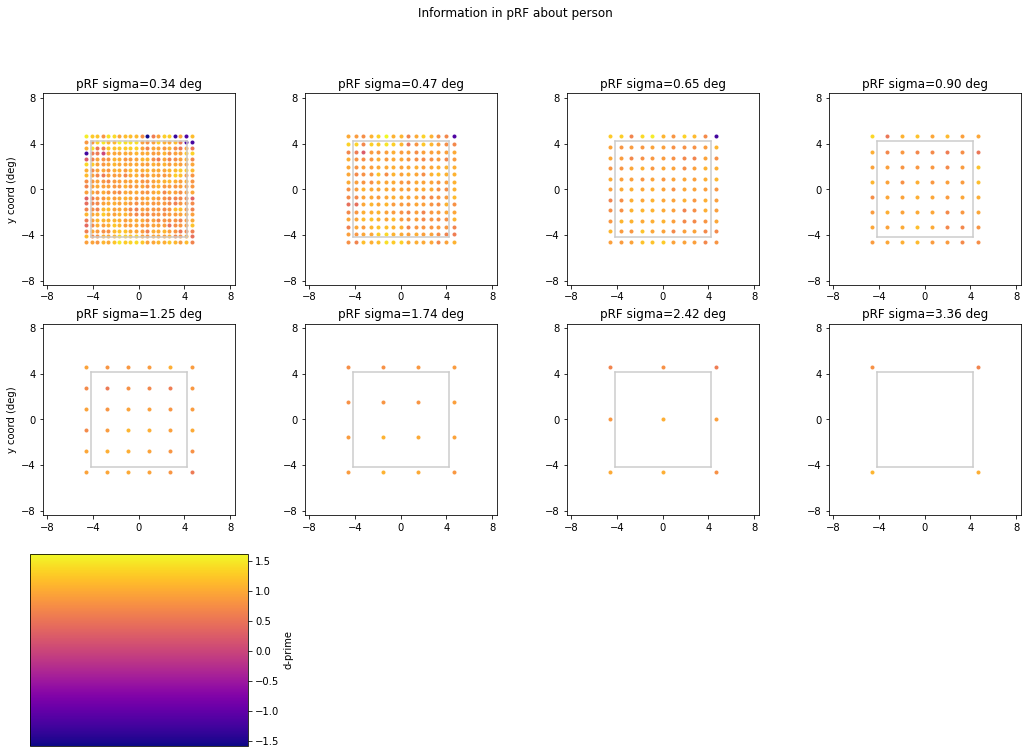

In [99]:
prf_models = models

unique_sizes = np.unique(np.round(prf_models[:,2],4))

plt.figure(figsize=(18,12));

n_color_steps = 100
colors = cm.plasma(np.linspace(0,1,n_color_steps))
dprime_range = [np.min(np.array(lda_result['val_dprime'])), \
                np.max(np.array(lda_result['val_dprime']))]
dprime_steps = np.linspace(dprime_range[0], dprime_range[1], n_color_steps)
screen_eccen_deg = 8.4
xylims = 1.0*screen_eccen_deg

for si, size in enumerate(unique_sizes):

    inds = np.where(np.round(prf_models[:,2],4)==size)[0]

    prf_models_plot = models[inds,:]
    dprime_plot = np.array(lda_result['val_dprime'])[inds]
    plt.subplot(3,4,si+1)
    ax = plt.gca()
        
    for mm in range(len(prf_models_plot)):
        x,y,sigma = prf_models_plot[mm,:]
        dprime = dprime_plot[mm]
        color_ind = np.argmin(np.abs(dprime_steps-dprime))
        plt.plot(x*screen_eccen_deg,y*screen_eccen_deg,'.', color=colors[color_ind,:])  
        
    plt.axis('square')
    plt.xlim([-xylims, xylims])
    plt.ylim([-xylims, xylims])
    plt.xticks(np.arange(-8,9,4))
    plt.yticks(np.arange(-8,9,4))
    
    plt.plot([screen_eccen_deg/2,screen_eccen_deg/2], [screen_eccen_deg/2, -screen_eccen_deg/2],color=[0.8, 0.8, 0.8])
    plt.plot([-screen_eccen_deg/2,-screen_eccen_deg/2], [screen_eccen_deg/2, -screen_eccen_deg/2],color=[0.8, 0.8, 0.8])
    plt.plot([-screen_eccen_deg/2,screen_eccen_deg/2], [screen_eccen_deg/2, screen_eccen_deg/2],color=[0.8, 0.8, 0.8])
    plt.plot([-screen_eccen_deg/2,screen_eccen_deg/2], [-screen_eccen_deg/2, -screen_eccen_deg/2],color=[0.8, 0.8, 0.8])

    if si>7:
        plt.xlabel('x coord (deg)')
    if np.mod(si,4)==0:
        plt.ylabel('y coord (deg)')

    plt.title('pRF sigma=%.2f deg'%(size*screen_eccen_deg))
    
ax = plt.subplot(3,4,si+2)
scalmap = cm.ScalarMappable(matplotlib.colors.Normalize(vmin=dprime_range[0], vmax=dprime_range[1]),\
                  cmap='plasma')
fig.colorbar(scalmap, orientation='vertical', label='d-prime',cax=ax)

plt.suptitle('Information in pRF about %s'%discrim_type);

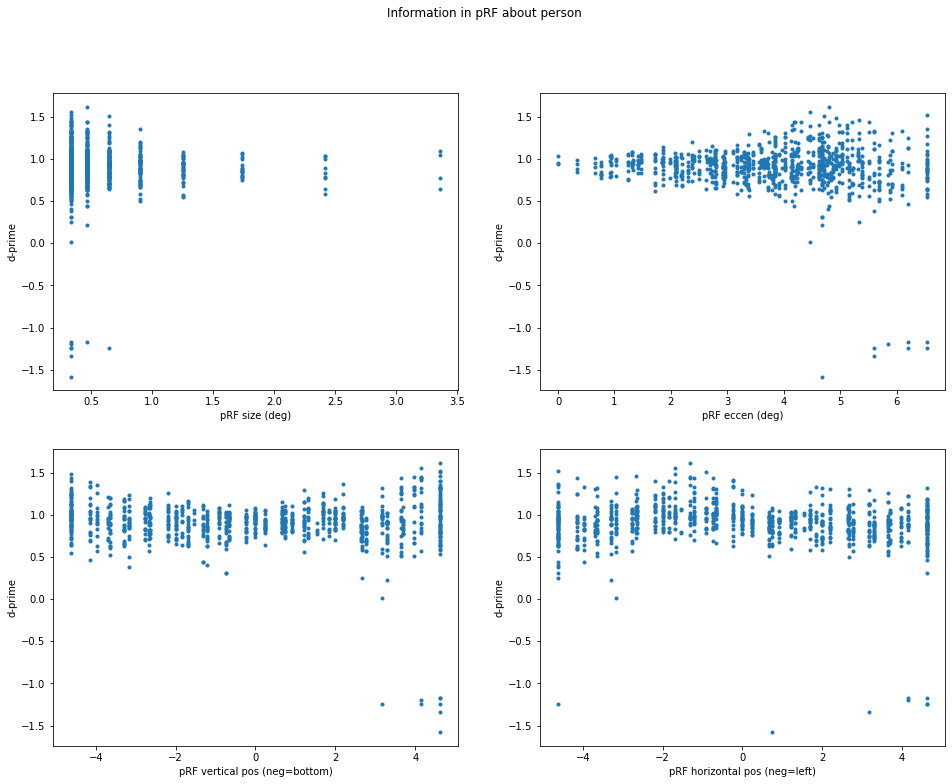

In [100]:
plt.figure(figsize=(16,12));
dprime_vals = np.array(lda_result['val_dprime'])

plt.subplot(2,2,1)
plt.plot(models[:,2]*screen_eccen_deg, dprime_vals,'.')
plt.xlabel('pRF size (deg)')
plt.ylabel('d-prime')

plt.subplot(2,2,2)
plt.plot(np.sqrt(models[:,0]**2+models[:,1]**2)*screen_eccen_deg, dprime_vals,'.')
plt.xlabel('pRF eccen (deg)')
plt.ylabel('d-prime')

plt.subplot(2,2,3)
plt.plot(models[:,1]*screen_eccen_deg, dprime_vals,'.')
plt.xlabel('pRF vertical pos (neg=bottom)')
plt.ylabel('d-prime')

plt.subplot(2,2,4)
plt.plot(models[:,0]*screen_eccen_deg, dprime_vals,'.')
plt.xlabel('pRF horizontal pos (neg=left)')
plt.ylabel('d-prime')

plt.suptitle('Information in pRF about %s'%discrim_type);

In [51]:
dprime_steps[color_ind]

1.011732560774039

In [34]:
lda_result['labels_actual'][0].shape

(10000,)

In [35]:
np.unique(lda_result['labels_actual'][0])

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [37]:
np.unique(lda_result['labels_pred'][0])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [102]:
lda_result['val_acc'][0]!=1

True